In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from verstack import NaNImputer

import warnings
warnings.filterwarnings("ignore")

### Load data

In [ ]:
train = pd.read_csv("https://raw.githubusercontent.com/MohamedMostafa259/Customer-Churn-Prediction-and-Analysis/main/Data/train_split.csv")
train.sample(5, random_state=42)

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
18484,fffe43004900440034003500360031003800,Miguelina Roepke,45,F,8S00926,Town,No Membership,2016-01-28,Yes,CID2780,...,182.19,11470.90,23.0,598.62,No,Yes,Yes,Solved in Follow-up,Poor Website,5.0
22374,fffe43004900440033003500360032003500,Giselle Aumick,48,F,9LAVTBJ,Town,Premium Membership,2017-01-30,Yes,CID37509,...,220.78,20578.73,8.0,795.09,Yes,Yes,No,Not Applicable,Poor Website,3.0
25235,fffe43004900440034003800350037003600,Merlyn Chadwell,56,F,ZUA3VGF,Town,Silver Membership,2016-02-03,?,CID5182,...,254.72,28425.26,11.0,789.30,Yes,Yes,No,Not Applicable,No reason specified,3.0
26952,fffe4300490044003900370037003700,Ranae Zoller,51,F,RI9KL4C,Town,No Membership,2016-05-16,No,xxxxxxxx,...,36.53,20551.93,15.0,699.68,No,Yes,No,Not Applicable,Poor Product Quality,5.0
12273,fffe43004900440035003200320031003800,Herbert Soucy,57,M,NSJKN6G,Town,No Membership,2016-01-05,No,xxxxxxxx,...,334.43,32965.31,29.0,690.62,Yes,Yes,No,Not Applicable,No reason specified,5.0


### Quick Background

Initially, the dataset only contained two files: `train.csv` and `test.csv`. However, the `test.csv` file didn't include any target labels, and since the HackerEarth competition had already ended, I couldn't use it to evaluate my model's performance.

**Solution:**  
To address this, I manually split the original `train.csv` into two separate sets: a new `train_split.csv` and a `validation_split.csv`, using the code below:

```python
train['churn_risk_score'].value_counts(dropna=False)
```

**Output:**
```bash
churn_risk_score
 3    10424
 4    10185
 5     9827
 2     2741
 1     2652
-1     1163  # WRONG Label!! → needs to be removed
```

```python
# replace invalid target (-1) with NaN and drop them
train.loc[train['churn_risk_score'] == -1, 'churn_risk_score'] = np.nan
train = train.dropna(subset=['churn_risk_score'])

train, validation = train_test_split(train, test_size=0.2, random_state=42, stratify=train['churn_risk_score'])

# save new datasets
validation.to_csv('validation.csv', index=False)
train.to_csv('train.csv', index=False)
```

### Create a copy for cleaning

In [11]:
train_copy = train.copy()

### Investigate the dataset

In [12]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28663 entries, 0 to 28662
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   28663 non-null  object 
 1   Name                          28663 non-null  object 
 2   age                           28663 non-null  int64  
 3   gender                        28663 non-null  object 
 4   security_no                   28663 non-null  object 
 5   region_category               24493 non-null  object 
 6   membership_category           28663 non-null  object 
 7   joining_date                  28663 non-null  object 
 8   joined_through_referral       28663 non-null  object 
 9   referral_id                   28663 non-null  object 
 10  preferred_offer_types         28439 non-null  object 
 11  medium_of_operation           28663 non-null  object 
 12  internet_option               28663 non-null  object 
 13  l

In [13]:
train_copy.describe()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,points_in_wallet,churn_risk_score
count,28663.000000,28663.000000,28663.000000,28663.000000,26002.000000,28663.000000
mean,37.184384,-42.771657,245.133200,29324.275164,686.470434,3.608206
std,15.825000,230.488181,398.524659,19496.233240,194.686815,1.176464
min,10.000000,-999.000000,-2814.109110,800.460000,-549.357498,1.000000
25%,24.000000,8.000000,59.770000,14191.665000,615.687500,3.000000
50%,37.000000,12.000000,162.290000,27574.120000,697.450000,4.000000
75%,51.000000,16.000000,358.280000,40874.025000,763.785000,5.000000
max,64.000000,26.000000,3235.578521,99914.050000,2069.069761,5.000000


## Data cleaning

#### Handling negative values

In [14]:
train_copy.loc[train_copy['days_since_last_login'] < 0, 'days_since_last_login'] = np.nan
train_copy.loc[train_copy['avg_time_spent'] < 0, 'avg_time_spent'] = np.nan
train_copy.loc[train_copy['points_in_wallet'] < 0, 'points_in_wallet'] = np.nan

In [15]:
train_copy.describe()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,points_in_wallet,churn_risk_score
count,28663.000000,27090.000000,27353.000000,28663.000000,25894.000000,28663.000000
mean,37.184384,12.752418,293.627492,29324.275164,690.032021,3.608206
std,15.825000,5.563637,333.197256,19496.233240,186.900502,1.176464
min,10.000000,1.000000,15.114910,800.460000,6.432208,1.000000
25%,24.000000,9.000000,71.240000,14191.665000,616.870000,3.000000
50%,37.000000,13.000000,174.490000,27574.120000,698.190000,4.000000
75%,51.000000,17.000000,372.710000,40874.025000,764.125000,5.000000
max,64.000000,26.000000,3235.578521,99914.050000,2069.069761,5.000000


#### Visualizing distributions

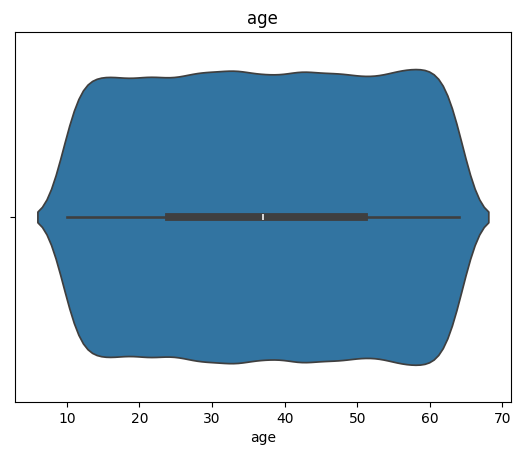

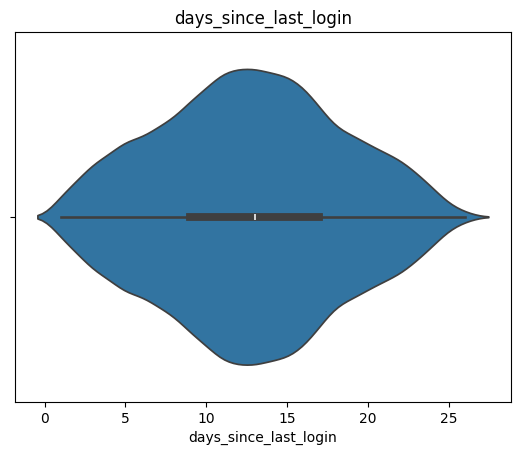

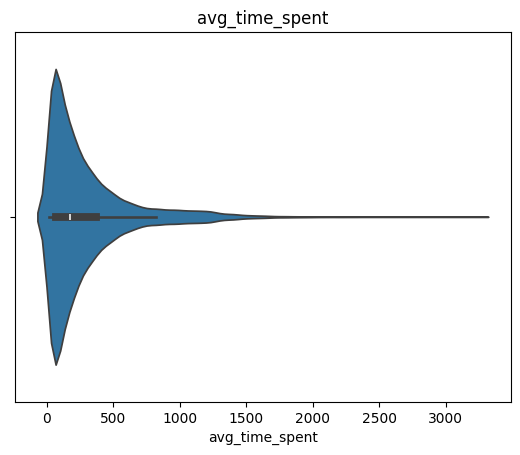

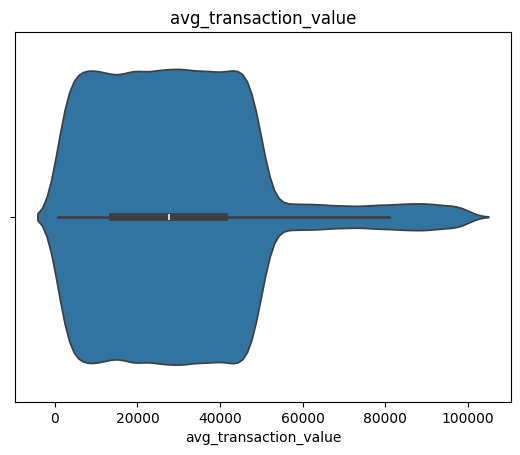

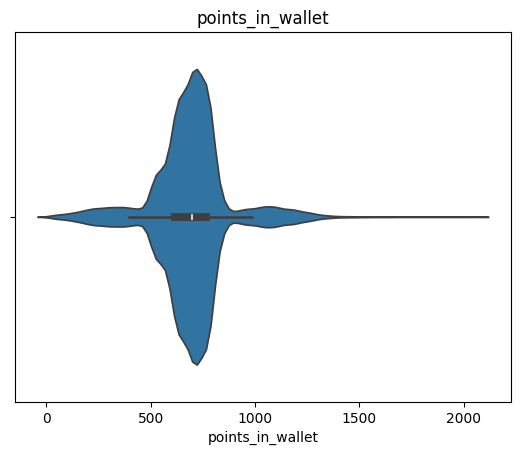

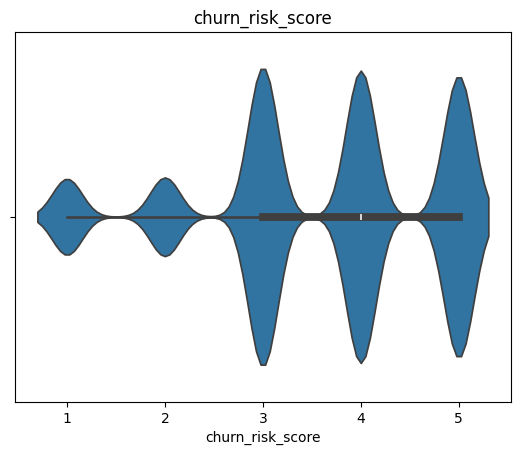

In [16]:
for col in train_copy.describe().columns:
	sns.violinplot(train_copy, x=col)
	plt.title(col)
	plt.show()

In [17]:
# cols_with_outliers = ['avg_time_spent', 'avg_transaction_value', 'points_in_wallet']

Some columns have non-normal and non-uniform distributions. Also, they have outliers; however, I will not cap these outliers because they may introduce an important pattern in the data, for example, if `avg_transaction_value` has some very high values due to VIP customers, capping them may remove valuable patterns.

So, I will apply log transformation to `avg_time_spent` to make it look more normal as it's right-skewed.

#### Log transformation

In [18]:
# log1p(x) = log(x + 1): this avoids errors when x = 0
train_copy['log_avg_time_spent'] = np.log1p(train_copy['avg_time_spent'])

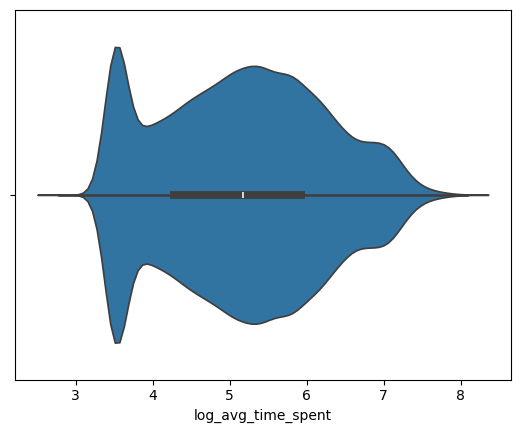

In [19]:
sns.violinplot(train_copy, x='log_avg_time_spent')
plt.show()

### Check duplicates

In [20]:
train_copy.duplicated(['customer_id']).sum()

0

### Handling missing values 

In [21]:
for col in train_copy.select_dtypes(include='object').columns:
	print(train_copy[col].value_counts(normalize=True, dropna=False))
	print('-'*50)

customer_id
fffe43004900440034003500300039003600    0.000035
fffe4300490044003100300039003500        0.000035
fffe43004900440032003500330030003000    0.000035
fffe43004900440034003500300035003500    0.000035
fffe43004900440032003300330035003500    0.000035
                                          ...   
fffe43004900440031003100310031003900    0.000035
fffe43004900440035003200340034003600    0.000035
fffe43004900440035003000390030003700    0.000035
fffe43004900440035003800300032003000    0.000035
fffe43004900440035003400370035003200    0.000035
Name: proportion, Length: 28663, dtype: float64
--------------------------------------------------
Name
Jena Vasser          0.000035
Annamaria Thiry      0.000035
Lizette Jeffreys     0.000035
Gay Flick            0.000035
Keitha Soucy         0.000035
                       ...   
Nolan Jelley         0.000035
Odessa Spicher       0.000035
Mellissa Fitting     0.000035
Kristeen Cadieux     0.000035
Luciana Garibaldi    0.000035
Name: proportio

In [22]:
# drop 'avg_frequency_login_days' because most of it is missing
cols_to_drop = ['customer_id', 'Name', 'security_no', 'referral_id', 'avg_frequency_login_days']

# date_cols = [('date', 'date_format'), ...]
date_cols = [('joining_date', '%Y-%m-%d'), ('last_visit_time', '%H:%M:%S')]

### Sanity check

`referral_id` should be populated only when `joined_through_referral` is "Yes"

In [23]:
train_copy['referral_id'].isna().sum()

0

In [24]:
# TODO: There're lots of columns seems to have inconsistent data; how to deal with them?!
wrong_rows = ((train_copy['referral_id'] != 'xxxxxxxx') & (train_copy['joined_through_referral'] == 'No')) | \
				((train_copy['referral_id'] == 'xxxxxxxx') & (train_copy['joined_through_referral'] == 'Yes'))
train_copy.loc[wrong_rows]

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score,log_avg_time_spent
17,fffe43004900440032003400320037003700,Kristeen Swiger,13,F,H3K1TT9,NaN,Platinum Membership,2016-02-03,Yes,xxxxxxxx,...,38603.09,18.0,1020.617065,No,Yes,Yes,Solved in Follow-up,Reasonable Price,1.0,4.904904
35,fffe43004900440035003400340031003300,Rosia Mcelyea,25,F,E7XRRP4,City,Premium Membership,2016-10-25,Yes,xxxxxxxx,...,40516.47,12.0,707.710000,No,Yes,Yes,Solved in Follow-up,Poor Website,3.0,NaN
38,fffe43004900440034003800300033003900,Shakira Brugger,44,M,3M85GI5,City,No Membership,2015-07-16,Yes,xxxxxxxx,...,40778.12,Error,584.200000,Yes,Yes,Yes,Solved,Poor Website,5.0,6.125383
46,fffe43004900440032003600320031003500,Shakira Alameda,13,F,MU9YN1M,City,Basic Membership,2016-12-26,Yes,xxxxxxxx,...,1941.17,24.0,NaN,Yes,No,Yes,Unsolved,Poor Website,5.0,4.995657
73,fffe43004900440032003800380039003200,Hilde Dumlao,22,F,VKC4W6J,NaN,Basic Membership,2015-09-08,Yes,xxxxxxxx,...,27991.19,Error,664.240000,No,Yes,No,Not Applicable,Poor Product Quality,4.0,4.708178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28495,fffe4300490044003400350039003300,Brinda Ballenger,22,F,FA1YQU4,NaN,Premium Membership,2015-05-24,Yes,xxxxxxxx,...,20740.21,32.40694172050272,733.450000,Yes,No,Yes,No Information Available,Poor Customer Service,3.0,6.224875
28502,fffe43004900440034003900310034003700,Aaron Scotti,64,F,E6YV2AZ,NaN,Basic Membership,2015-12-13,Yes,xxxxxxxx,...,914.85,-20.087771035847595,NaN,No,Yes,Yes,Solved in Follow-up,Poor Product Quality,5.0,5.636966
28531,fffe43004900440036003200320039003000,Zelda Goertz,44,F,2SKW3R6,NaN,No Membership,2017-06-06,Yes,xxxxxxxx,...,25870.87,12.0,1006.694613,Yes,No,Yes,Unsolved,No reason specified,5.0,6.413115
28562,fffe43004900440034003100390035003900,Yang Galgano,12,F,EE2H4YP,City,Premium Membership,2016-11-07,Yes,xxxxxxxx,...,46493.02,26.0,773.650000,No,Yes,Yes,Solved,No reason specified,3.0,5.168892


I prefer to not remove them because first we need to go back the data owners and ask them what it means when 'referral_id' is equal to 'xxxxxxxx'. 

### Drop unnecessary cols


In [25]:
train_copy = train_copy.drop(columns=cols_to_drop)

In [26]:
cat_cols = list(set(train_copy.select_dtypes(include='object').columns) - set(date_cols))
# last_visit_time → categories: morning & evening, ...
cat_cols

['preferred_offer_types',
 'used_special_discount',
 'joined_through_referral',
 'last_visit_time',
 'feedback',
 'internet_option',
 'membership_category',
 'offer_application_preference',
 'gender',
 'region_category',
 'past_complaint',
 'joining_date',
 'complaint_status',
 'medium_of_operation']

#### Set unknown categories to `Nan`

In [27]:
# train_copy.loc[train_copy['joined_through_referral']=='?', 'joined_through_referral'] = np.nan
# train_copy.loc[train_copy['medium_of_operation']=='?', 'medium_of_operation'] = np.nan
train_copy = train_copy.replace('?', np.nan)

#### Identify missing values

In [28]:
train_copy.isna().sum()

age                                0
gender                             0
region_category                 4170
membership_category                0
joining_date                       0
joined_through_referral         4231
preferred_offer_types            224
medium_of_operation             4211
internet_option                    0
last_visit_time                    0
days_since_last_login           1573
avg_time_spent                  1310
avg_transaction_value              0
points_in_wallet                2769
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
log_avg_time_spent              1310
dtype: int64

- Drop rows where target variable is missing

In [29]:
train_copy = train_copy.drop(train_copy.loc[train_copy['churn_risk_score'].isna()].index)

-	Check remaining columns with Nans

In [30]:
train_copy.isna().sum()

age                                0
gender                             0
region_category                 4170
membership_category                0
joining_date                       0
joined_through_referral         4231
preferred_offer_types            224
medium_of_operation             4211
internet_option                    0
last_visit_time                    0
days_since_last_login           1573
avg_time_spent                  1310
avg_transaction_value              0
points_in_wallet                2769
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
log_avg_time_spent              1310
dtype: int64

##### **Handling missing value approach**

I will use `verstack.NaNImputer` for powerful model-based imputation

## Building the whole pipeline

### DataCleaner Transformer

This transformer:

-	drops unwanted cols

-	replace unknown categories (e.g., '?') with `np.nan`

-	handle wrong negative values 

In [31]:
class DataCleaner(BaseEstimator, TransformerMixin):
	def __init__(self, cols_to_drop):
		self.cols_to_drop = cols_to_drop
   
	def fit(self, X, y=None):
		return self

	# X is pd.DataFrame
	def transform(self, X):
		X_copy = X.copy()
		X_copy.drop(columns=self.cols_to_drop, inplace=True)	
			
		X_copy.replace("?", np.nan, inplace=True)

		for col in ['days_since_last_login', 'avg_time_spent', 'points_in_wallet']:
			X_copy.loc[X_copy[col] < 0, col] = np.nan  

		return X_copy

####  Wrapping `verstack.NaNImputer` into an custom transformer for compatibility with scikit-learn's API

In [32]:
class NaNImputerWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, train_sample_size=30_000, verbose=True):
        self.train_sample_size = train_sample_size
        self.verbose = verbose
        self.imputer = NaNImputer(self.train_sample_size, self.verbose)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return self.imputer.impute(X)

### Integrating transformers into a pipeline

In [33]:
X_train = train.drop(columns=['churn_risk_score'])
y_train = train['churn_risk_score']

In [34]:
cleaning_pipeline = Pipeline([
    ('dataCleaner', DataCleaner(cols_to_drop)), 
    ('imputer', NaNImputerWrapper(train_sample_size=train.shape[0]))
])

X_train_cleaned = cleaning_pipeline.fit_transform(X_train)


 * Initiating NaNImputer.impute
     . Dataset dimensions:
     .. rows:         28663
     .. columns:      19
     .. mb in memory: 4.16
     .. NaN cols num: 7

   - Drop hopeless NaN cols

   - Processing whole data for imputation
     . Processed 10 cols; 7 to go

   - Imputing single core 7 cols
     . Imputed (multiclass) - 4170     NaN in region_category
     . Imputed (  binary  ) - 4231     NaN in joined_through_referral
     . Imputed (multiclass) - 224      NaN in preferred_offer_types
     . Imputed (multiclass) - 4211     NaN in medium_of_operation
     . Imputed (multiclass) - 1573     NaN in days_since_last_login
     . Imputed (regression) - 1310     NaN in avg_time_spent
     . Imputed (regression) - 2769     NaN in points_in_wallet

   - Missing values after imputation: 0

Time elapsed for impute execution: 38.83968 seconds


In [35]:
X_train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28663 entries, 0 to 28662
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           28663 non-null  int64  
 1   gender                        28663 non-null  object 
 2   region_category               28663 non-null  object 
 3   membership_category           28663 non-null  object 
 4   joining_date                  28663 non-null  object 
 5   joined_through_referral       28663 non-null  object 
 6   preferred_offer_types         28663 non-null  object 
 7   medium_of_operation           28663 non-null  object 
 8   internet_option               28663 non-null  object 
 9   last_visit_time               28663 non-null  object 
 10  days_since_last_login         28663 non-null  float64
 11  avg_time_spent                28663 non-null  float64
 12  avg_transaction_value         28663 non-null  float64
 13  p

### Save cleaned data

In [36]:
train_cleaned = pd.concat([X_train_cleaned, y_train], axis=1)
train_cleaned.to_csv('train_cleaned.csv', index=False)

### Save `cleaning_pipeline`

In [37]:
import joblib
joblib.dump(cleaning_pipeline, 'cleaning_pipeline.joblib')

['cleaning_pipeline.joblib']